# 0. Introduction

In [494]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [495]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv("datasets/titanic/train.csv")
df_test = pd.read_csv("datasets/titanic/test.csv")
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


# 1. Exploratory Data Analysis

## 1.1 Overview

In [496]:
pd.concat([df_train, df_test], sort=True).index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            408, 409, 410, 411, 412, 413, 414, 415, 416, 417],
           dtype='int64', length=1309)

In [497]:
pd.concat([df_train, df_test], sort=True).reset_index(drop=True).index

RangeIndex(start=0, stop=1309, step=1)

In [498]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
623,624,0,3,"Hansen, Mr. Henry Damsgaard",male,21.0,0,0,350029,7.8542,NaN,S
316,317,1,2,"Kantor, Mrs. Sinai (Miriam Sternin)",female,24.0,1,0,244367,26.0000,NaN,S
459,460,0,3,"O'Connor, Mr. Maurice",male,NaN,0,0,371060,7.7500,NaN,Q


In [499]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
132,1024,3,"Lefebre, Mrs. Frank (Frances)",female,NaN,0,4,4133,25.4667,NaN,S
161,1053,3,"Touma, Master. Georges Youssef",male,7.0,1,1,2650,15.2458,NaN,C
340,1232,2,"Fillbrook, Mr. Joseph Charles",male,18.0,0,0,C.A. 15185,10.5000,NaN,S


## 1.2 MISSING VALUES

As seen from below, some columns have missing values. display_missing function shows the count of missing values in every column in both training and test set.

Training set have missing values in Age, Cabin and Embarked columns
Test set have missing values in Age, Cabin and Fare columns

It is convenient to work on concatenated training and test set while dealing with missing values, otherwise filled data may overfit to training or test set samples. The count of missing values in Age, Embarked and Fare are smaller compared to total sample, but roughly 80% of the Cabin is missing. Missing values in Age, Embarked and Fare can be filled with descriptive statistical measures but that wouldn't work for Cabin.

In [500]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




### 1.2.1 Age

In [501]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [502]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Pclass']

,Feature 1,Feature 2,Correlation Coefficient
4,Pclass,Pclass,1.000000
8,Pclass,Fare,0.558629
10,Pclass,Age,0.408106
13,Pclass,Survived,0.338481
32,Pclass,SibSp,0.060832
35,Pclass,PassengerId,0.038354
43,Pclass,Parch,0.018322


In [503]:
df_all_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Feature 1                49 non-null     object 
 1   Feature 2                49 non-null     object 
 2   Correlation Coefficient  49 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.3+ KB


In [504]:
df_all.corr().abs()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
Age,1.000000,0.178740,0.150917,0.028814,0.408106,0.243699,0.077221
Fare,0.178740,1.000000,0.221539,0.031428,0.558629,0.160238,0.257307
Parch,0.150917,0.221539,1.000000,0.008942,0.018322,0.373587,0.081629
PassengerId,0.028814,0.031428,0.008942,1.000000,0.038354,0.055224,0.005007
Pclass,0.408106,0.558629,0.018322,0.038354,1.000000,0.060832,0.338481
SibSp,0.243699,0.160238,0.373587,0.055224,0.060832,1.000000,0.035322
Survived,0.077221,0.257307,0.081629,0.005007,0.338481,0.035322,1.000000


In [505]:
 df_all.corr().abs().unstack()

Age          Age            1.000000
             Fare           0.178740
             Parch          0.150917
             PassengerId    0.028814
             Pclass         0.408106
             SibSp          0.243699
             Survived       0.077221
Fare         Age            0.178740
             Fare           1.000000
             Parch          0.221539
             PassengerId    0.031428
             Pclass         0.558629
             SibSp          0.160238
             Survived       0.257307
Parch        Age            0.150917
             Fare           0.221539
             Parch          1.000000
             PassengerId    0.008942
             Pclass         0.018322
             SibSp          0.373587
             Survived       0.081629
PassengerId  Age            0.028814
             Fare           0.031428
             Parch          0.008942
             PassengerId    1.000000
             Pclass         0.038354
             SibSp          0.055224
 

In [506]:
df_all.corr().abs().unstack().sort_values()

Survived     PassengerId    0.005007
PassengerId  Survived       0.005007
Parch        PassengerId    0.008942
PassengerId  Parch          0.008942
Parch        Pclass         0.018322
Pclass       Parch          0.018322
PassengerId  Age            0.028814
Age          PassengerId    0.028814
Fare         PassengerId    0.031428
PassengerId  Fare           0.031428
Survived     SibSp          0.035322
SibSp        Survived       0.035322
PassengerId  Pclass         0.038354
Pclass       PassengerId    0.038354
SibSp        PassengerId    0.055224
PassengerId  SibSp          0.055224
Pclass       SibSp          0.060832
SibSp        Pclass         0.060832
Survived     Age            0.077221
Age          Survived       0.077221
Parch        Survived       0.081629
Survived     Parch          0.081629
Parch        Age            0.150917
Age          Parch          0.150917
SibSp        Fare           0.160238
Fare         SibSp          0.160238
Age          Fare           0.178740
F

In [507]:
df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False)

Survived     Survived       1.000000
SibSp        SibSp          1.000000
Fare         Fare           1.000000
Parch        Parch          1.000000
Pclass       Pclass         1.000000
PassengerId  PassengerId    1.000000
Age          Age            1.000000
Fare         Pclass         0.558629
Pclass       Fare           0.558629
Age          Pclass         0.408106
Pclass       Age            0.408106
Parch        SibSp          0.373587
SibSp        Parch          0.373587
Pclass       Survived       0.338481
Survived     Pclass         0.338481
             Fare           0.257307
Fare         Survived       0.257307
Age          SibSp          0.243699
SibSp        Age            0.243699
Parch        Fare           0.221539
Fare         Parch          0.221539
             Age            0.178740
Age          Fare           0.178740
Fare         SibSp          0.160238
SibSp        Fare           0.160238
Age          Parch          0.150917
Parch        Age            0.150917
S

In [508]:
df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()

,level_0,level_1,0
0,Survived,Survived,1.000000
1,SibSp,SibSp,1.000000
2,Fare,Fare,1.000000
3,Parch,Parch,1.000000
4,Pclass,Pclass,1.000000
5,PassengerId,PassengerId,1.000000
6,Age,Age,1.000000
7,Fare,Pclass,0.558629
8,Pclass,Fare,0.558629
9,Age,Pclass,0.408106


In order to be more accurate, Sex feature is used as the second level of groupby while filling the missing Age values. As seen from below, Pclass and Sex groups have distinct median Age values. When passenger class increases, the median age for both males and females also increases. However, females tend to have slightly lower median Age than males. The median ages below are used for filling the missing values in Age feature.

In [509]:
df_all.groupby(['Sex', 'Pclass']).median()

Age      Fare  Parch  PassengerId  SibSp  Survived
Sex    Pclass                                                     
female 1       36.0  80.92915      0          710      0       1.0
       2       28.0  23.00000      0          589      0       1.0
       3       22.0  10.48960      0          637      0       0.5
male   1       42.0  49.50420      0          648      0       0.0
       2       29.5  13.00000      0          715      0       0.0
       3       25.0   7.89580      0          649      0       0.0

In [510]:
df_all.groupby(['Sex', 'Pclass']).median()['Age']

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

In [511]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']
for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [512]:
# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [513]:
print(df_all.groupby(['Sex', 'Pclass'])['Fare'].median(), "\n")
print(df_all.groupby(['Sex', 'Pclass'])['Age'].median(), "\n")
print(df_all.groupby(['Sex', 'Pclass']).median()['Fare'], "\n")
print(df_all.groupby(['Sex', 'Pclass']).median()['Age'], "\n")

Sex     Pclass
female  1         80.92915
        2         23.00000
        3         10.48960
male    1         49.50420
        2         13.00000
        3          7.89580
Name: Fare, dtype: float64 

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64 

Sex     Pclass
female  1         80.92915
        2         23.00000
        3         10.48960
male    1         49.50420
        2         13.00000
        3          7.89580
Name: Fare, dtype: float64 

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64 



Embarked is a categorical feature and there are only 2 missing values in whole data set. Both of those passengers are female, upper class and they have the same ticket number. This means that they know each other and embarked from the same port together. The mode Embarked value for an upper class female passenger is C (Cherbourg), but this doesn't necessarily mean that they embarked from that port.

### 1.2.2 Embarked

In [514]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [515]:
# Filling the missing values in Embarked with S
df_all['Embarked'] = df_all['Embarked'].fillna('S')

### 1.2.3 Fare

There is only one passenger with missing Fare value. We can assume that Fare is related to family size (Parch and SibSp) and Pclass features. Median Fare value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [516]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [517]:
df_all['Fare'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
1304    False
1305    False
1306    False
1307    False
1308    False
Name: Fare, Length: 1309, dtype: bool

In [518]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
med_fare

7.8542

In [519]:
df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()

Pclass  Parch  SibSp
1       0      0         31.33960
               1         75.25000
               2         51.47920
        1      0         63.35830
               1         83.15830
        2      0         83.15830
               1        120.00000
               2        262.37500
               3        263.00000
        3      1        262.37500
        4      1        263.00000
2       0      0         13.00000
               1         26.00000
               2         73.50000
               3         21.00000
        1      0         23.00000
               1         26.25000
               2         33.00000
        2      0         26.25000
               1         41.57920
        3      0         39.00000
               1         23.00000
               2         18.75000
3       0      0          7.85420
               1         14.45625
               2         19.83960
               3         16.92500
        1      0         12.47500
               1         15

In [520]:
df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3]

Parch  SibSp
0      0         7.85420
       1        14.45625
       2        19.83960
       3        16.92500
1      0        12.47500
       1        15.24580
       2        19.25830
       3        22.02500
       4        34.40625
2      0        15.24580
       1        22.01250
       2        34.37500
       3        27.90000
       4        31.27500
       5        46.90000
       8        69.55000
3      0        19.25830
       1        34.37500
4      0        23.27085
       1        27.90000
5      0        34.40625
       1        31.33125
6      1        46.90000
9      1        69.55000
Name: Fare, dtype: float64

In [521]:
df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0]

SibSp
0     7.85420
1    14.45625
2    19.83960
3    16.92500
Name: Fare, dtype: float64

In [522]:
df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]

7.8542

In [523]:
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

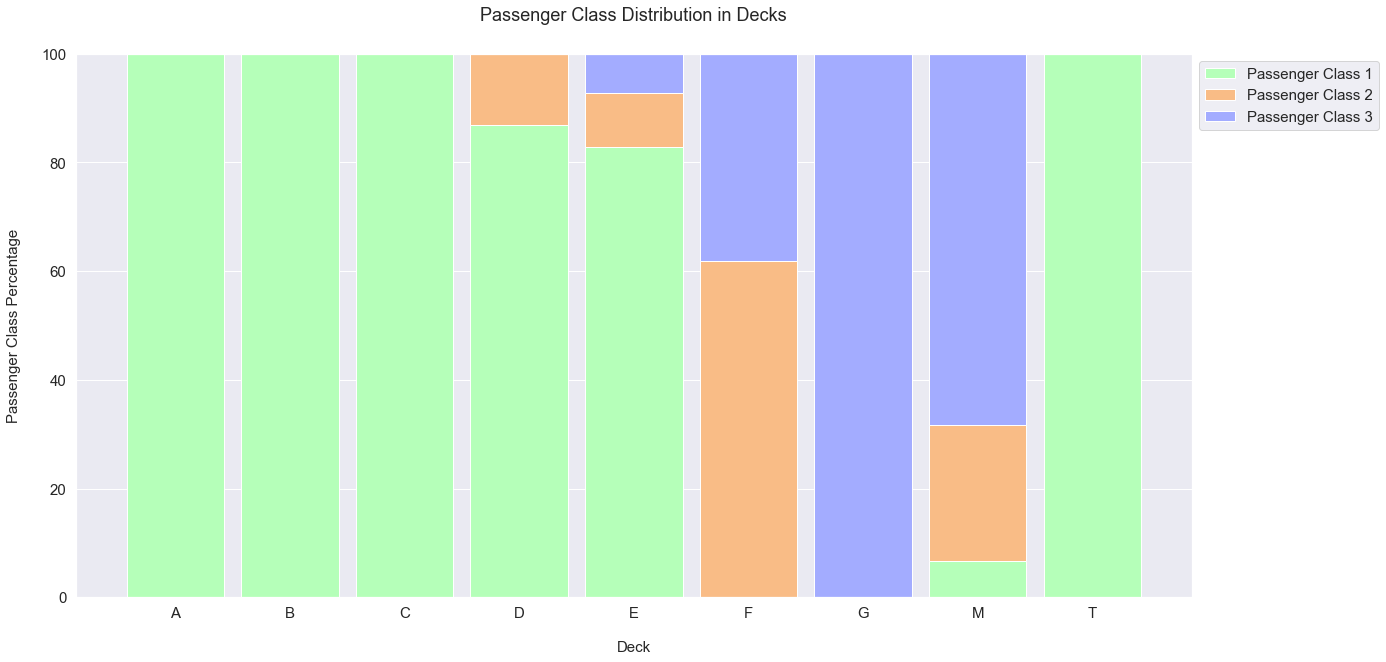

In [524]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 
                                                                        'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 
                                                                        'PassengerId', 'Ticket']).rename(
    columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [525]:
 df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

0       M
1       C
2       M
3       C
4       M
       ..
1304    M
1305    C
1306    M
1307    M
1308    M
Name: Cabin, Length: 1309, dtype: object

In [526]:
df_all.groupby(['Deck', 'Pclass']).count().drop(
    columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
             'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

In [527]:
df_all.groupby(['Deck', 'Pclass']).count()

Age  Cabin  Embarked  Fare  Name  Parch  PassengerId  Sex  SibSp  \
Deck Pclass                                                                     
A    1        22     22        22    22    22     22           22   22     22   
B    1        65     65        65    65    65     65           65   65     65   
C    1        94     94        94    94    94     94           94   94     94   
D    1        40     40        40    40    40     40           40   40     40   
     2         6      6         6     6     6      6            6    6      6   
E    1        34     34        34    34    34     34           34   34     34   
     2         4      4         4     4     4      4            4    4      4   
     3         3      3         3     3     3      3            3    3      3   
F    2        13     13        13    13    13     13           13   13     13   
     3         8      8         8     8     8      8            8    8      8   
G    3         5      5         5     5     5      5            5    5      5   
M    1        67      0        67    67    67     67           67   67     67   
     2       254      0       254   254   254    254          254  254    254   
     3       693      0       693   693   693    693          693  693    693   
T    1         1      1         1     1     1      1            1    1      1   

             Survived  Ticket  
Deck Pclass                    
A    1             15      22  
B    1             47      65  
C    1             59      94  
D    1             29      40  
     2              4       6  
E    1             25      34  
     2              4       4  
     3              3       3  
F    2              8      13  
     3              5       8  
G    3              4       5  
M    1             40      67  
     2            168     254  
     3            479     693  
T    1              1       1

In [528]:
df_all_decks

Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

In [529]:
df_all_decks.columns.levels

FrozenList([['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T'], [1, 2, 3]])

In [530]:
deck_counts, deck_percentages = get_pclass_dist(df_all_decks)

In [531]:
deck_counts

{'A': {1: 22, 2: 0, 3: 0},
 'B': {1: 65, 2: 0, 3: 0},
 'C': {1: 94, 2: 0, 3: 0},
 'D': {1: 40, 2: 6, 3: 0},
 'E': {1: 34, 2: 4, 3: 3},
 'F': {1: 0, 2: 13, 3: 8},
 'G': {1: 0, 2: 0, 3: 5},
 'M': {1: 67, 2: 254, 3: 693},
 'T': {1: 1, 2: 0, 3: 0}}

In [532]:
deck_percentages

{'A': [100.0, 0.0, 0.0],
 'B': [100.0, 0.0, 0.0],
 'C': [100.0, 0.0, 0.0],
 'D': [86.95652173913044, 13.043478260869565, 0.0],
 'E': [82.92682926829268, 9.75609756097561, 7.317073170731707],
 'F': [0.0, 61.904761904761905, 38.095238095238095],
 'G': [0.0, 0.0, 100.0],
 'M': [6.607495069033531, 25.04930966469428, 68.34319526627219],
 'T': [100.0, 0.0, 0.0]}

In [533]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

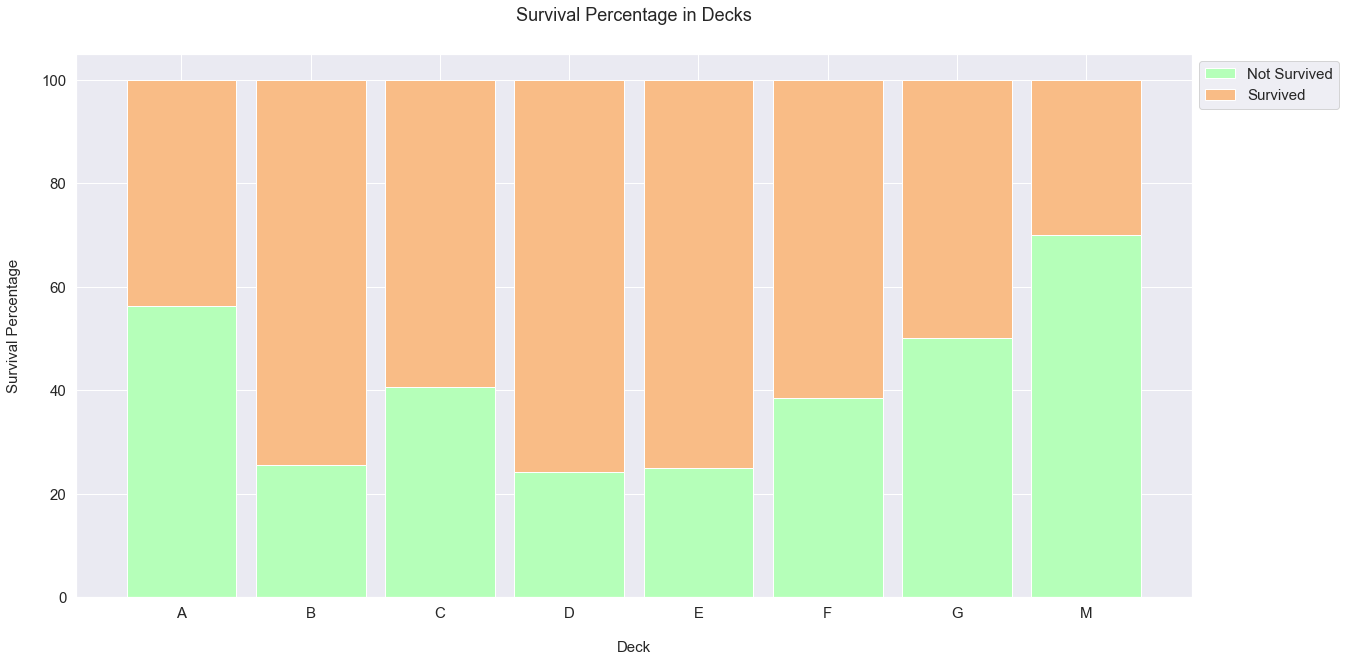

In [534]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(
    columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Pclass', 
             'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

In [535]:
df_all.groupby(['Deck', 'Survived']).count()

Age  Cabin  Embarked  Fare  Name  Parch  PassengerId  Pclass  \
Deck Survived                                                                 
A    0.0         9      9         9     9     9      9            9       9   
     1.0         7      7         7     7     7      7            7       7   
B    0.0        12     12        12    12    12     12           12      12   
     1.0        35     35        35    35    35     35           35      35   
C    0.0        24     24        24    24    24     24           24      24   
     1.0        35     35        35    35    35     35           35      35   
D    0.0         8      8         8     8     8      8            8       8   
     1.0        25     25        25    25    25     25           25      25   
E    0.0         8      8         8     8     8      8            8       8   
     1.0        24     24        24    24    24     24           24      24   
F    0.0         5      5         5     5     5      5            5       5   
     1.0         8      8         8     8     8      8            8       8   
G    0.0         2      2         2     2     2      2            2       2   
     1.0         2      2         2     2     2      2            2       2   
M    0.0       481      0       481   481   481    481          481     481   
     1.0       206      0       206   206   206    206          206     206   

               Sex  SibSp  Ticket  
Deck Survived                      
A    0.0         9      9       9  
     1.0         7      7       7  
B    0.0        12     12      12  
     1.0        35     35      35  
C    0.0        24     24      24  
     1.0        35     35      35  
D    0.0         8      8       8  
     1.0        25     25      25  
E    0.0         8      8       8  
     1.0        24     24      24  
F    0.0         5      5       5  
     1.0         8      8       8  
G    0.0         2      2       2  
     1.0         2      2       2  
M    0.0       481    481     481  
     1.0       206    206     206

In [536]:
df_all.groupby(['Deck', 'Survived']).count().drop(
    columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Pclass', 
             'Cabin', 'PassengerId', 'Ticket'])

Name
Deck Survived      
A    0.0          9
     1.0          7
B    0.0         12
     1.0         35
C    0.0         24
     1.0         35
D    0.0          8
     1.0         25
E    0.0          8
     1.0         24
F    0.0          5
     1.0          8
G    0.0          2
     1.0          2
M    0.0        481
     1.0        206

In [537]:
df_all.groupby(['Deck', 'Survived']).count().drop(
    columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Pclass', 
             'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'})

Count
Deck Survived       
A    0.0           9
     1.0           7
B    0.0          12
     1.0          35
C    0.0          24
     1.0          35
D    0.0           8
     1.0          25
E    0.0           8
     1.0          24
F    0.0           5
     1.0           8
G    0.0           2
     1.0           2
M    0.0         481
     1.0         206

In [538]:
df_all_decks_survived.columns.levels

FrozenList([['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M'], [0.0, 1.0]])

In [539]:
df_all_decks_survived.columns.levels[0]

Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M'], dtype='object', name='Deck')

In [540]:
get_survived_dist(df_all_decks_survived)

({'A': {0: 9, 1: 7},
  'B': {0: 12, 1: 35},
  'C': {0: 24, 1: 35},
  'D': {0: 8, 1: 25},
  'E': {0: 8, 1: 24},
  'F': {0: 5, 1: 8},
  'G': {0: 2, 1: 2},
  'M': {0: 481, 1: 206}},
 {'A': [56.25, 43.75],
  'B': [25.53191489361702, 74.46808510638297],
  'C': [40.67796610169492, 59.32203389830508],
  'D': [24.242424242424242, 75.75757575757575],
  'E': [25.0, 75.0],
  'F': [38.46153846153847, 61.53846153846154],
  'G': [50.0, 50.0],
  'M': [70.01455604075691, 29.985443959243085]})

In [541]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [542]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




### 1.3 Target Distribution

In [543]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

In [544]:
print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(
    survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(
    not_survived, df_train.shape[0], not_survived_per))

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


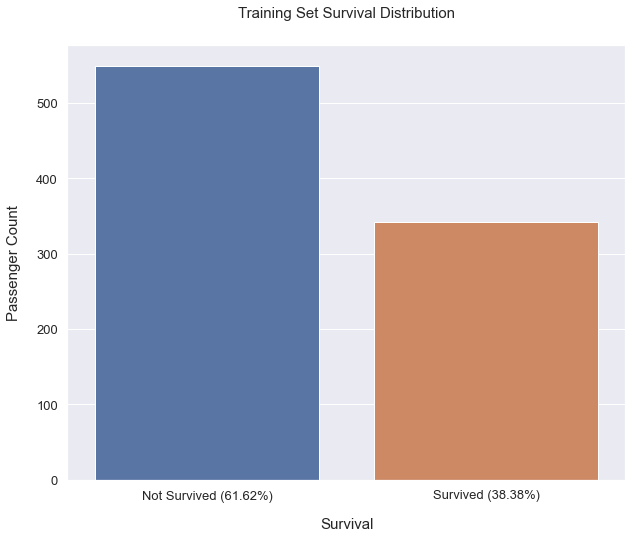

In [545]:
plt.figure(figsize=(10, 8))
sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

### 1.4 Correlations

In [546]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [547]:
df_train.drop(['PassengerId'], axis=1).corr().abs()

,Age,Fare,Parch,Pclass,SibSp,Survived
Age,1.000000,0.124061,0.176733,0.417667,0.249747,0.058635
Fare,0.124061,1.000000,0.216225,0.549500,0.159651,0.257307
Parch,0.176733,0.216225,1.000000,0.018443,0.414838,0.081629
Pclass,0.417667,0.549500,0.018443,1.000000,0.083081,0.338481
SibSp,0.249747,0.159651,0.414838,0.083081,1.000000,0.035322
Survived,0.058635,0.257307,0.081629,0.338481,0.035322,1.000000


In [548]:
df_train.drop(['PassengerId'], axis=1).corr().abs().unstack()

Age       Age         1.000000
          Fare        0.124061
          Parch       0.176733
          Pclass      0.417667
          SibSp       0.249747
          Survived    0.058635
Fare      Age         0.124061
          Fare        1.000000
          Parch       0.216225
          Pclass      0.549500
          SibSp       0.159651
          Survived    0.257307
Parch     Age         0.176733
          Fare        0.216225
          Parch       1.000000
          Pclass      0.018443
          SibSp       0.414838
          Survived    0.081629
Pclass    Age         0.417667
          Fare        0.549500
          Parch       0.018443
          Pclass      1.000000
          SibSp       0.083081
          Survived    0.338481
SibSp     Age         0.249747
          Fare        0.159651
          Parch       0.414838
          Pclass      0.083081
          SibSp       1.000000
          Survived    0.035322
Survived  Age         0.058635
          Fare        0.257307
        

In [549]:
df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False)

Survived  Survived    1.000000
SibSp     SibSp       1.000000
Fare      Fare        1.000000
Parch     Parch       1.000000
Pclass    Pclass      1.000000
Age       Age         1.000000
Pclass    Fare        0.549500
Fare      Pclass      0.549500
Pclass    Age         0.417667
Age       Pclass      0.417667
SibSp     Parch       0.414838
Parch     SibSp       0.414838
Survived  Pclass      0.338481
Pclass    Survived    0.338481
Survived  Fare        0.257307
Fare      Survived    0.257307
SibSp     Age         0.249747
Age       SibSp       0.249747
Parch     Fare        0.216225
Fare      Parch       0.216225
Age       Parch       0.176733
Parch     Age         0.176733
SibSp     Fare        0.159651
Fare      SibSp       0.159651
Age       Fare        0.124061
Fare      Age         0.124061
Pclass    SibSp       0.083081
SibSp     Pclass      0.083081
Survived  Parch       0.081629
Parch     Survived    0.081629
Age       Survived    0.058635
Survived  Age         0.058635
        

In [550]:
df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()

,level_0,level_1,0
0,Survived,Survived,1.000000
1,SibSp,SibSp,1.000000
2,Fare,Fare,1.000000
3,Parch,Parch,1.000000
4,Pclass,Pclass,1.000000
5,Age,Age,1.000000
6,Pclass,Fare,0.549500
7,Fare,Pclass,0.549500
8,Pclass,Age,0.417667
9,Age,Pclass,0.417667


In [551]:
df_train_corr.iloc[1::1]

,Feature 1,Feature 2,Correlation Coefficient
2,Fare,Fare,1.000000
4,Pclass,Pclass,1.000000
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733


In [552]:
df_train_corr.iloc[1::2]

,Feature 1,Feature 2,Correlation Coefficient
2,Fare,Fare,1.000000
6,Pclass,Fare,0.549500
10,SibSp,Parch,0.414838
14,Survived,Fare,0.257307
18,Parch,Fare,0.216225
22,SibSp,Fare,0.159651
26,Pclass,SibSp,0.083081
30,Age,Survived,0.058635
34,Parch,Pclass,0.018443


In [553]:
df_train_corr.iloc[1::3]

,Feature 1,Feature 2,Correlation Coefficient
2,Fare,Fare,1.000000
8,Pclass,Age,0.417667
14,Survived,Fare,0.257307
20,Age,Parch,0.176733
26,Pclass,SibSp,0.083081
32,Survived,SibSp,0.035322


In [554]:
df_train_corr.iloc[1::4]

,Feature 1,Feature 2,Correlation Coefficient
2,Fare,Fare,1.000000
10,SibSp,Parch,0.414838
18,Parch,Fare,0.216225
26,Pclass,SibSp,0.083081
34,Parch,Pclass,0.018443


In [555]:
df_train_corr.iloc[1:]

,Feature 1,Feature 2,Correlation Coefficient
2,Fare,Fare,1.000000
4,Pclass,Pclass,1.000000
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733


In [556]:
df_train_corr_nd

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [557]:
df_train_corr

,Feature 1,Feature 2,Correlation Coefficient
0,Survived,Survived,1.000000
2,Fare,Fare,1.000000
4,Pclass,Pclass,1.000000
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225


In [558]:
df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index

Int64Index([0, 2, 4], dtype='int64')

In [559]:
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [560]:
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Fare,Parch,0.230410
16,SibSp,Fare,0.172032


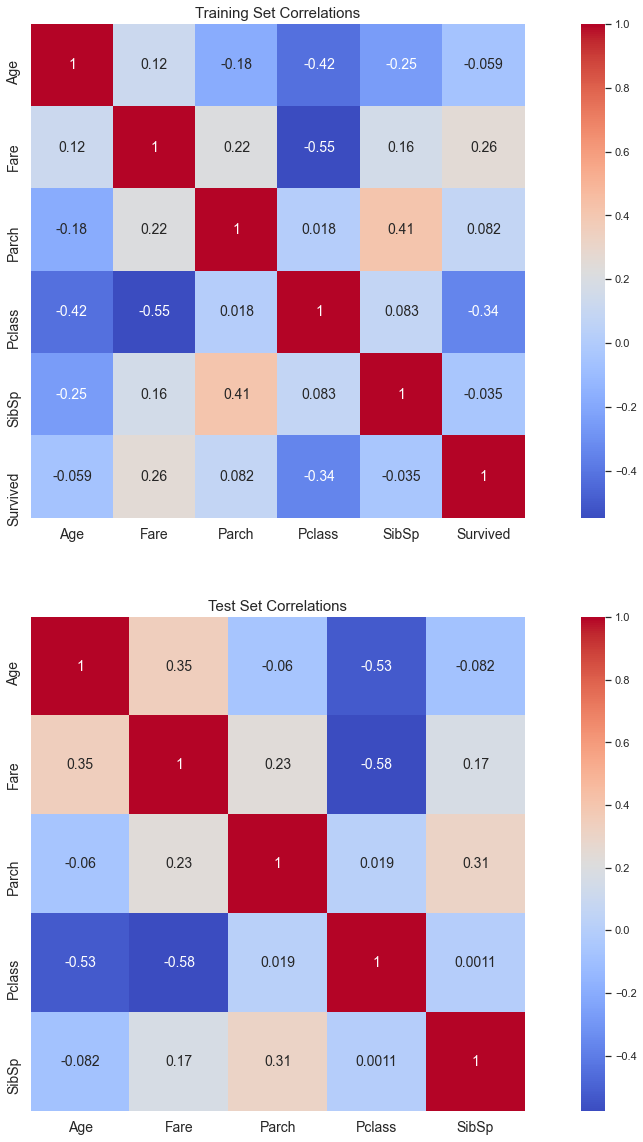

In [561]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

## 1.5 Target Distribution in Features

### 1.5.1 Continuous Features

Both of the continuous features (Age and Fare) have good split points and spikes for a decision tree to learn. One potential problem for both features is, the distribution has more spikes and bumps in training set, but it is smoother in test set. Model may not be able to generalize to test set because of this reason.

- Distribution of Age feature clearly shows that children younger than 15 has a higher survival rate than any of the other age groups
- In distribution of Fare feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extremely large outliers

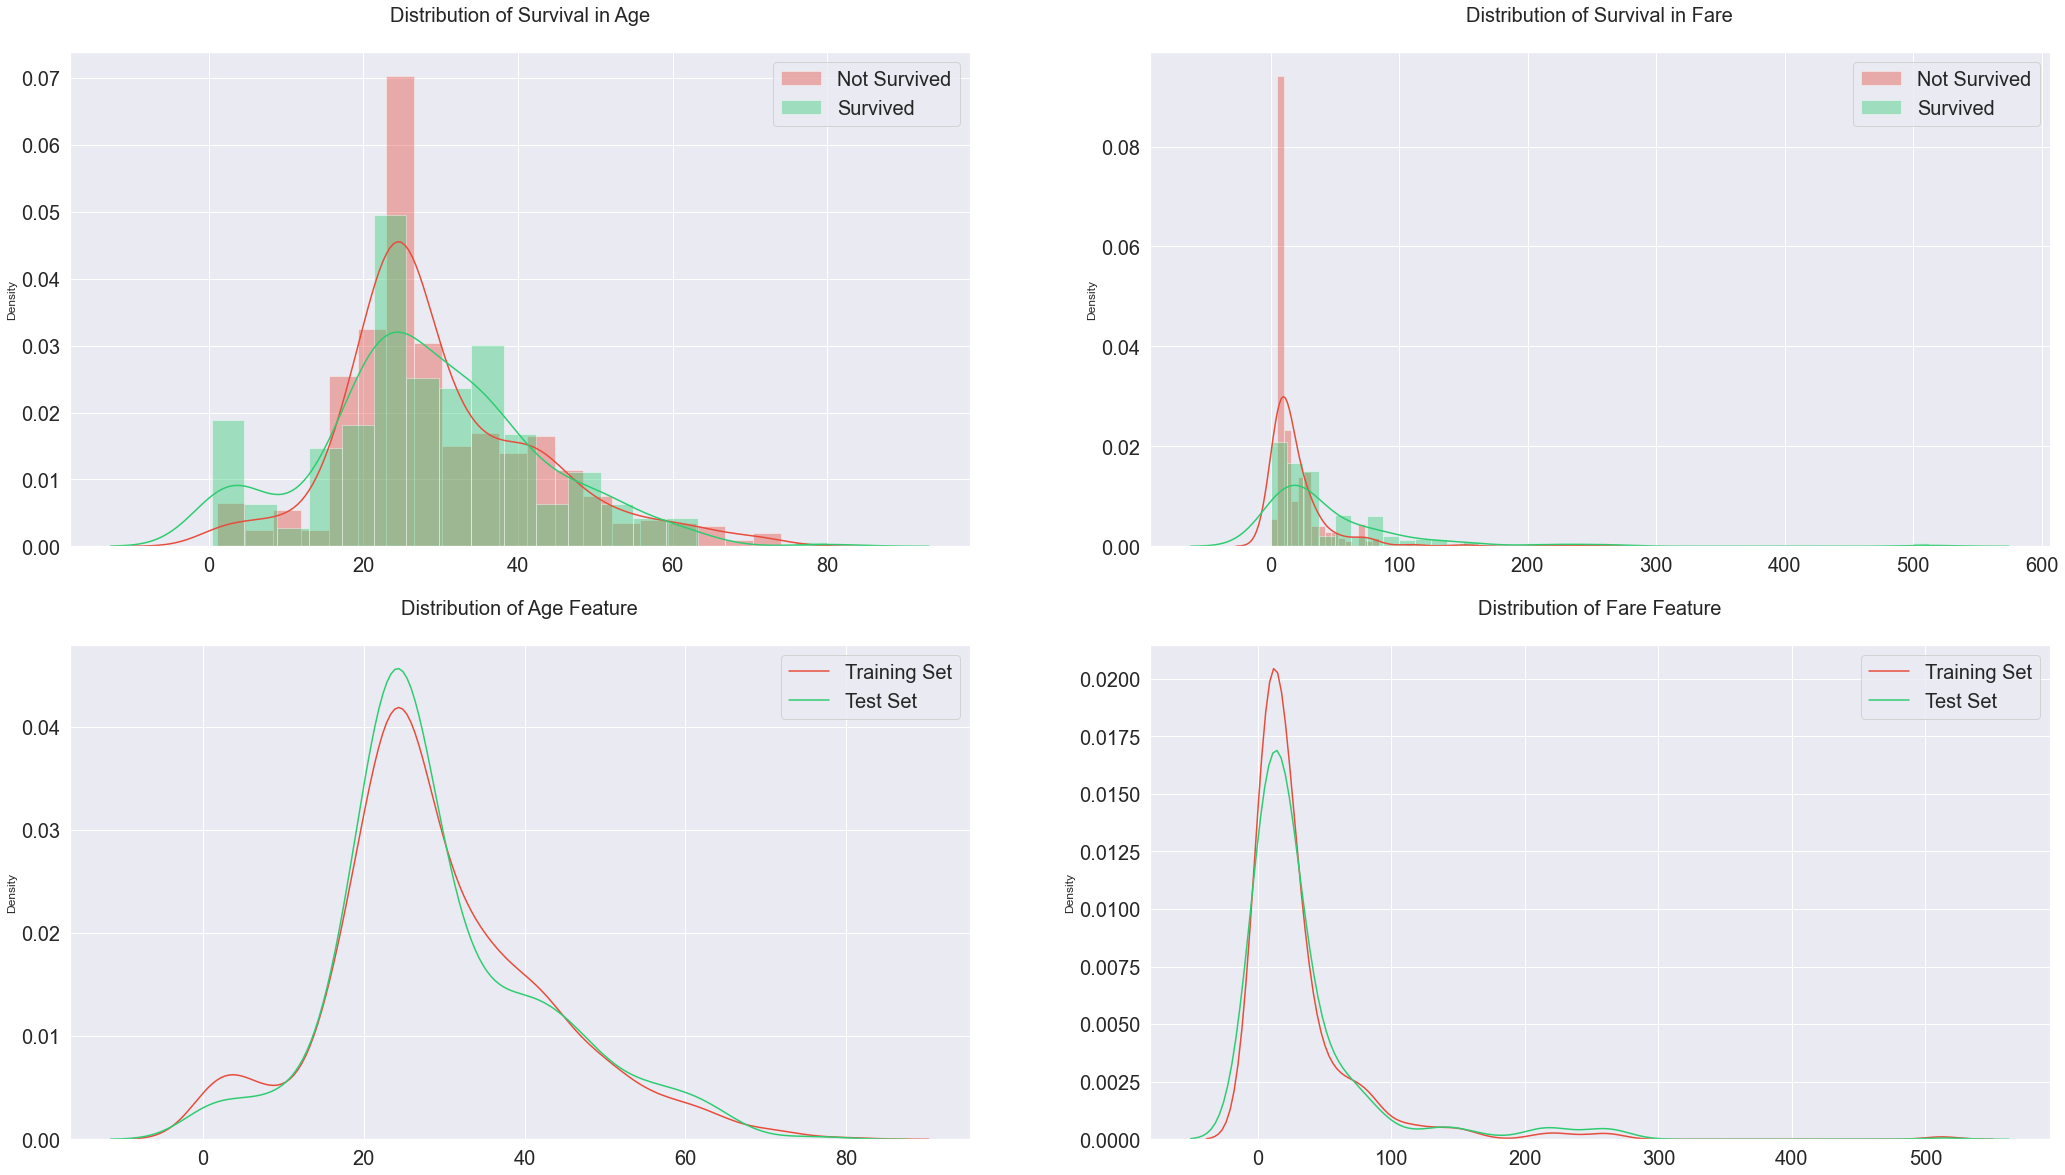

In [562]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

### 1.5.2 Categorical Features

Every categorical feature has at least one class with high mortality rate. Those classes are very helpful to predict whether the passenger is a survivor or victim. Best categorical features are Pclass and Sex because they have the most homogenous distributions.

- Passengers boarded from Southampton has a lower survival rate unlike other ports. More than half of the passengers boarded from Cherbourg had survived. This observation could be related to Pclass feature
- Parch and SibSp features show that passengers with only one family member has a higher survival rate

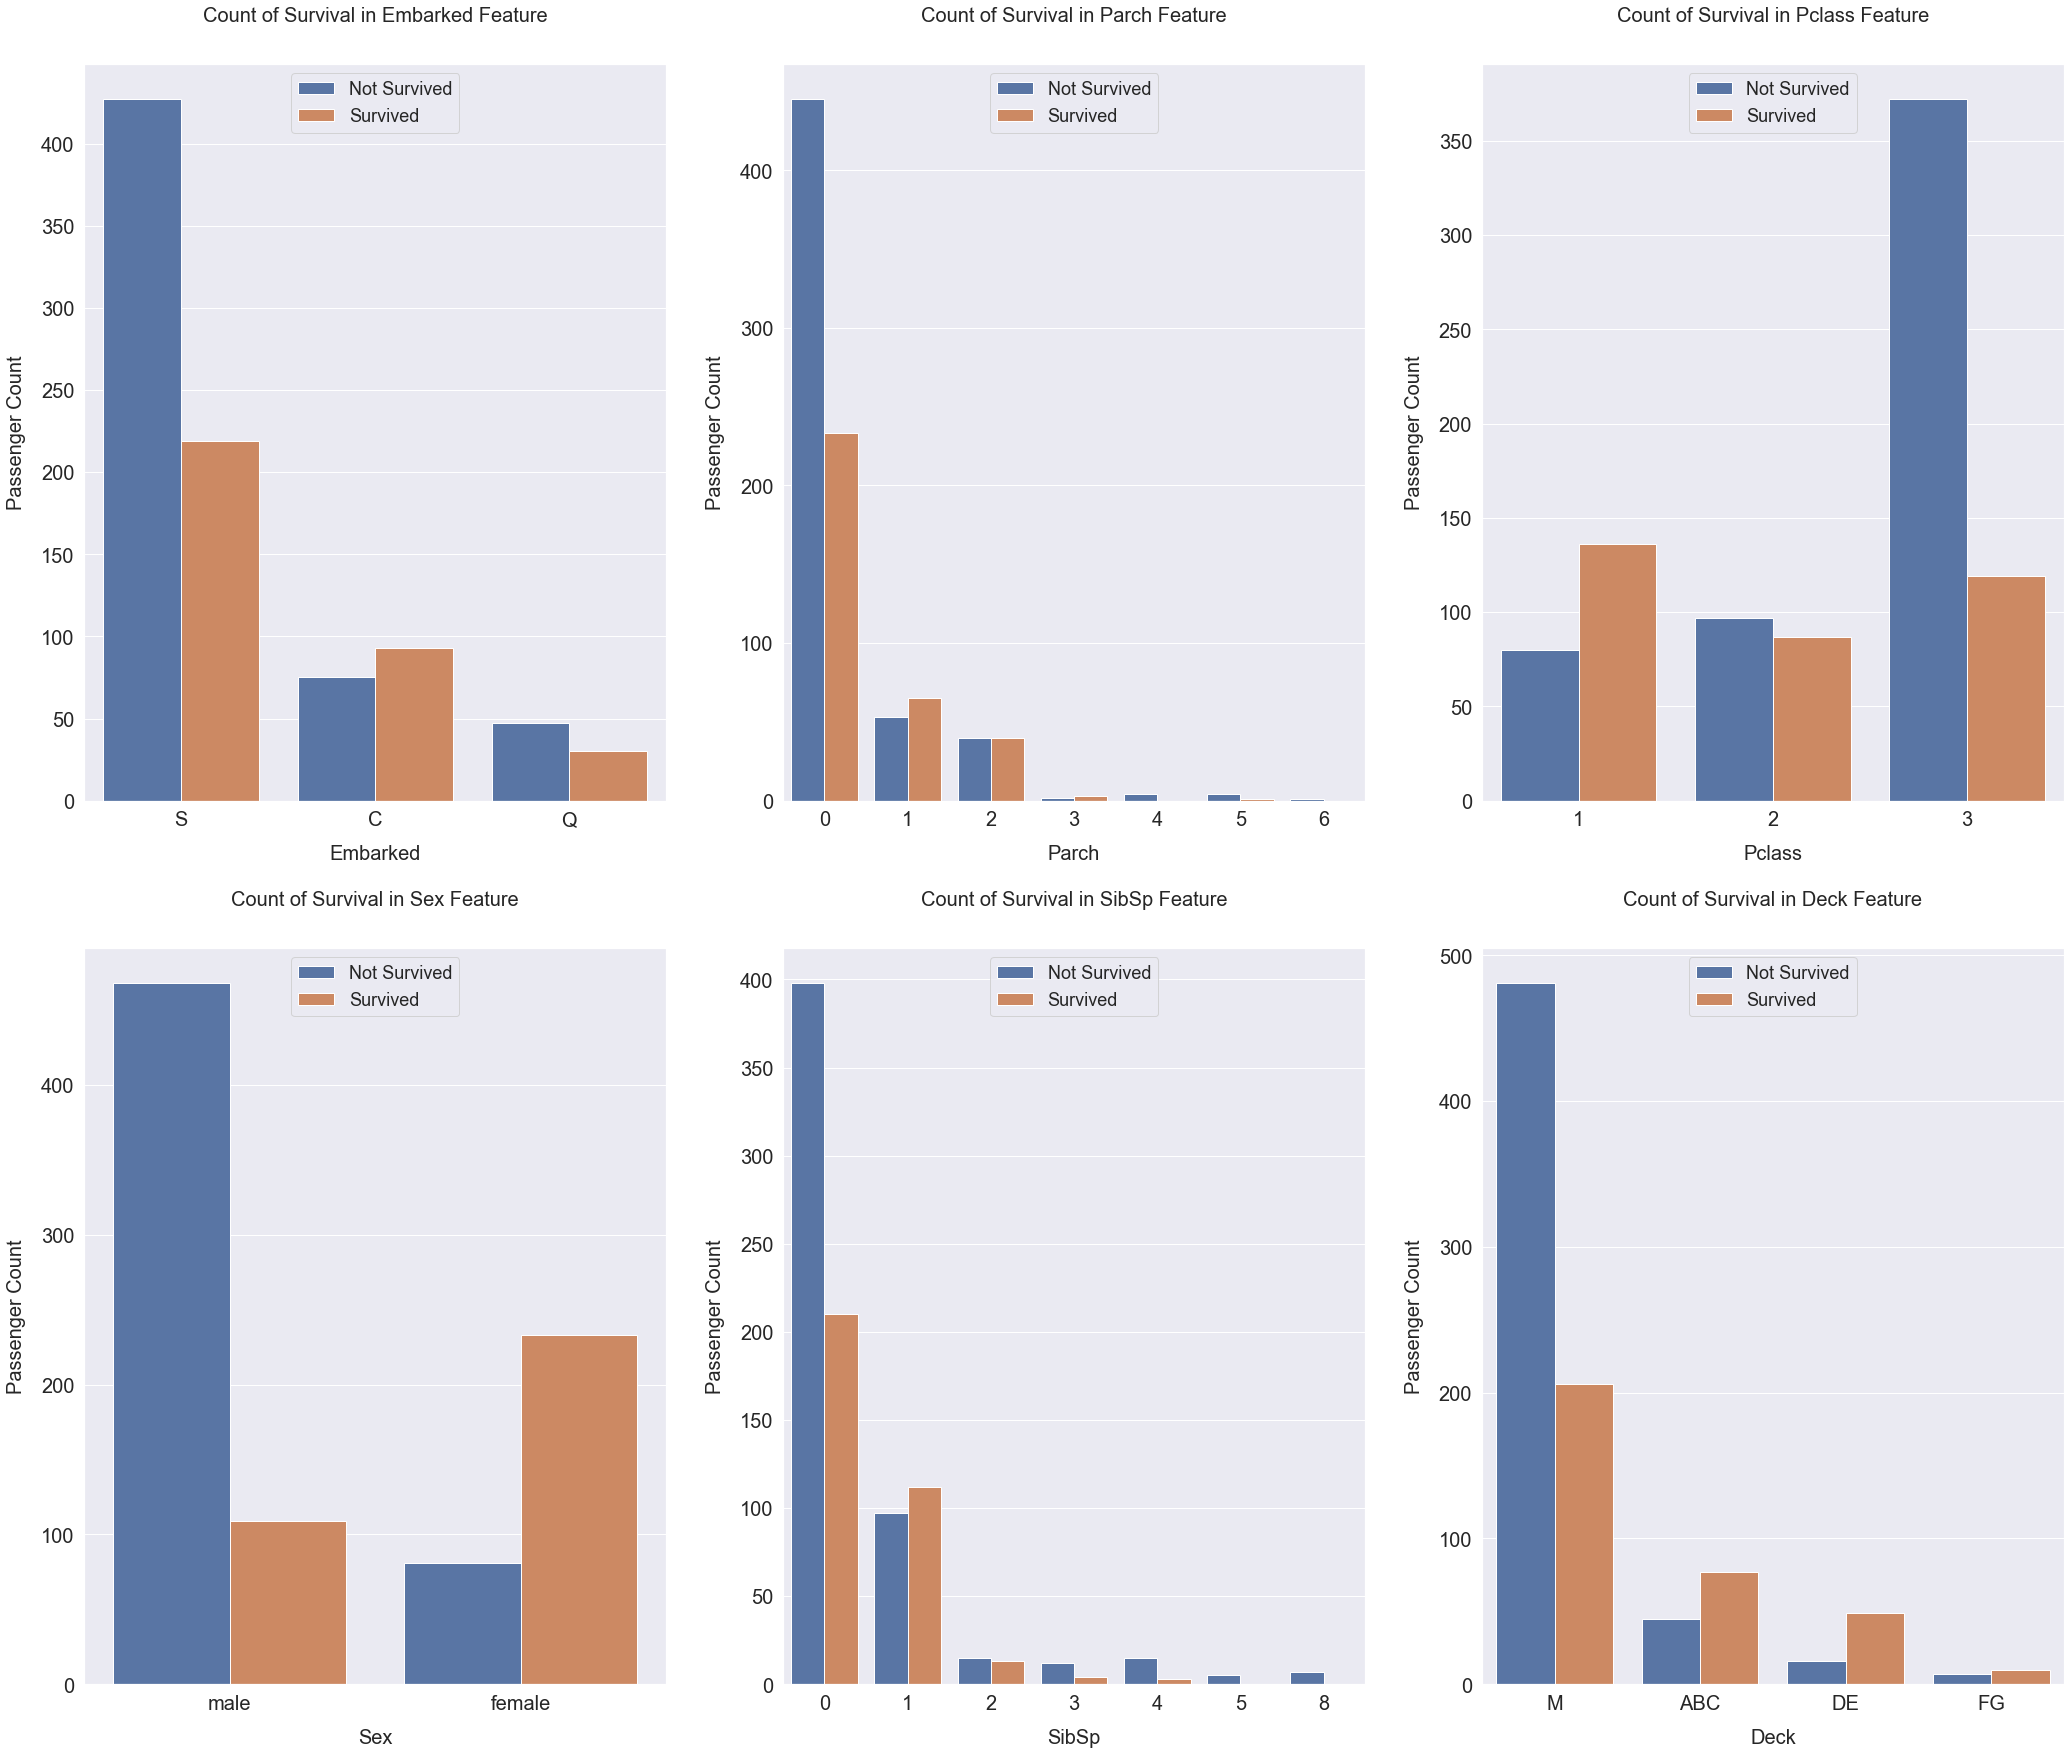

In [563]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

## 1.6 Conclusion

Most of the features are correlated with each other. This relationship can be used to create new features with feature transformation and feature interaction. Target encoding could be very useful as well because of the high correlations with Survived feature.

Split points and spikes are visible in continuous features. They can be captured easily with a decision tree model, but linear models may not be able to spot them.

Categorical features have very distinct distributions with different survival rates. Those features can be one-hot encoded. Some of those features may be combined with each other to make new features.

Created a new feature called Deck and dropped Cabin feature at the Exploratory Data Analysis part.

In [564]:
df_all = concat_df(df_train, df_test)
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


# 2. Feature Engineering

## 2.1 Binning Continuous Features

### 2.1.1 Fare

Fare feature is positively skewed and survival rate is extremely high on the right end. 13 quantile based bins are used for Fare feature. Even though the bins are too much, they provide decent amount of information gain. The groups at the left side of the graph has the lowest survival rate and the groups at the right side of the graph has the highest survival rate. This high survival rate was not visible in the distribution graph. There is also an unusual group (15.742, 23.25] in the middle with high survival rate that is captured in this process.

In [565]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

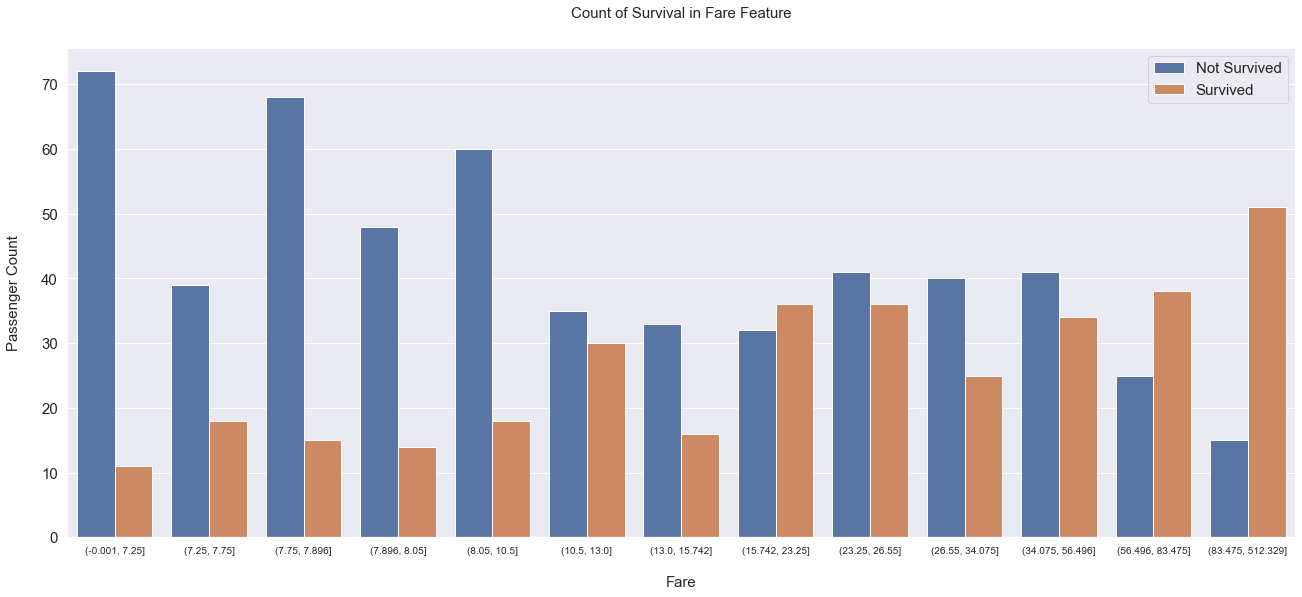

In [566]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

In [567]:
df_all['Fare']

0          (-0.001, 7.25]
1        (56.496, 83.475]
2           (7.896, 8.05]
3        (34.075, 56.496]
4           (7.896, 8.05]
              ...        
1304        (7.896, 8.05]
1305    (83.475, 512.329]
1306       (-0.001, 7.25]
1307        (7.896, 8.05]
1308      (15.742, 23.25]
Name: Fare, Length: 1309, dtype: category
Categories (13, interval[float64]): [(-0.001, 7.25] < (7.25, 7.75] < (7.75, 7.896] < (7.896, 8.05] ... (26.55, 34.075] < (34.075, 56.496] < (56.496, 83.475] < (83.475, 512.329]]

### 2.1.2 Age

Age feature has a normal distribution with some spikes and bumps and 10 quantile based bins are used for Age. The first bin has the highest survival rate and 4th bin has the lowest survival rate. Those were the biggest spikes in the distribution. There is also an unusual group (34.0, 40.0] with high survival rate that is captured in this process.

In [568]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

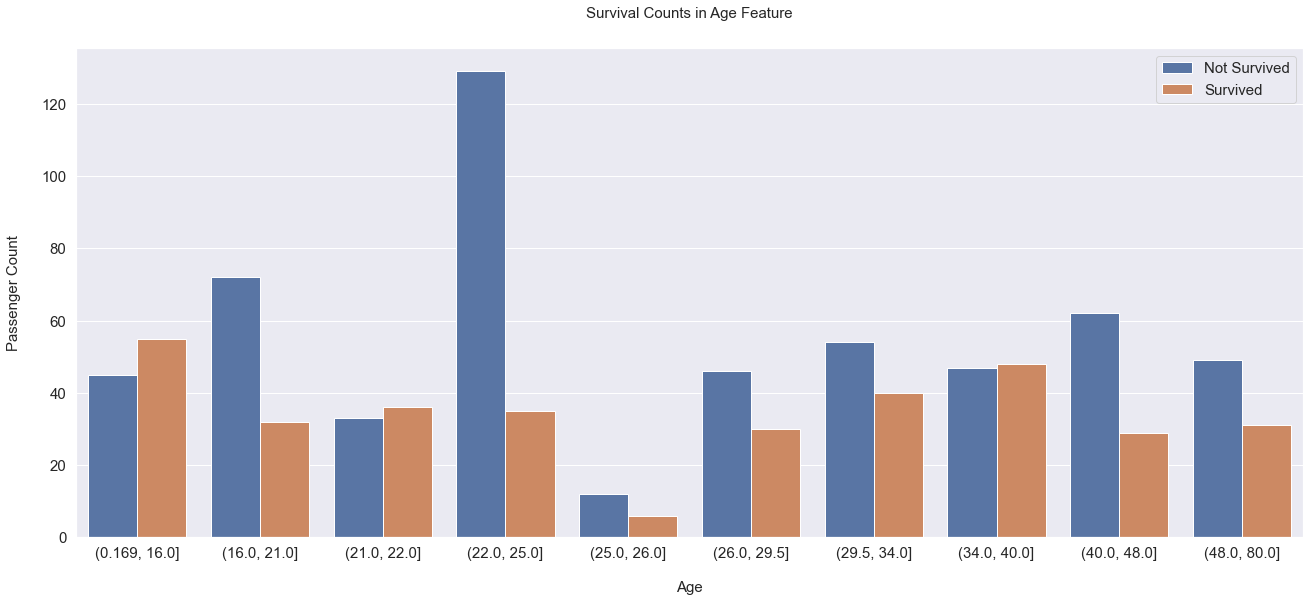

In [569]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

## 2.2 Frequency Encoding

Family_Size is created by adding SibSp, Parch and 1. SibSp is the count of siblings and spouse, and Parch is the count of parents and children. Those columns are added in order to find the total size of families. Adding 1 at the end, is the current passenger. Graphs have clearly shown that family size is a predictor of survival because different values have different survival rates.

- Family Size with 1 are labeled as Alone
- Family Size with 2, 3 and 4 are labeled as Small
- Family Size with 5 and 6 are labeled as Medium
- Family Size with 7, 8 and 11 are labeled as Large

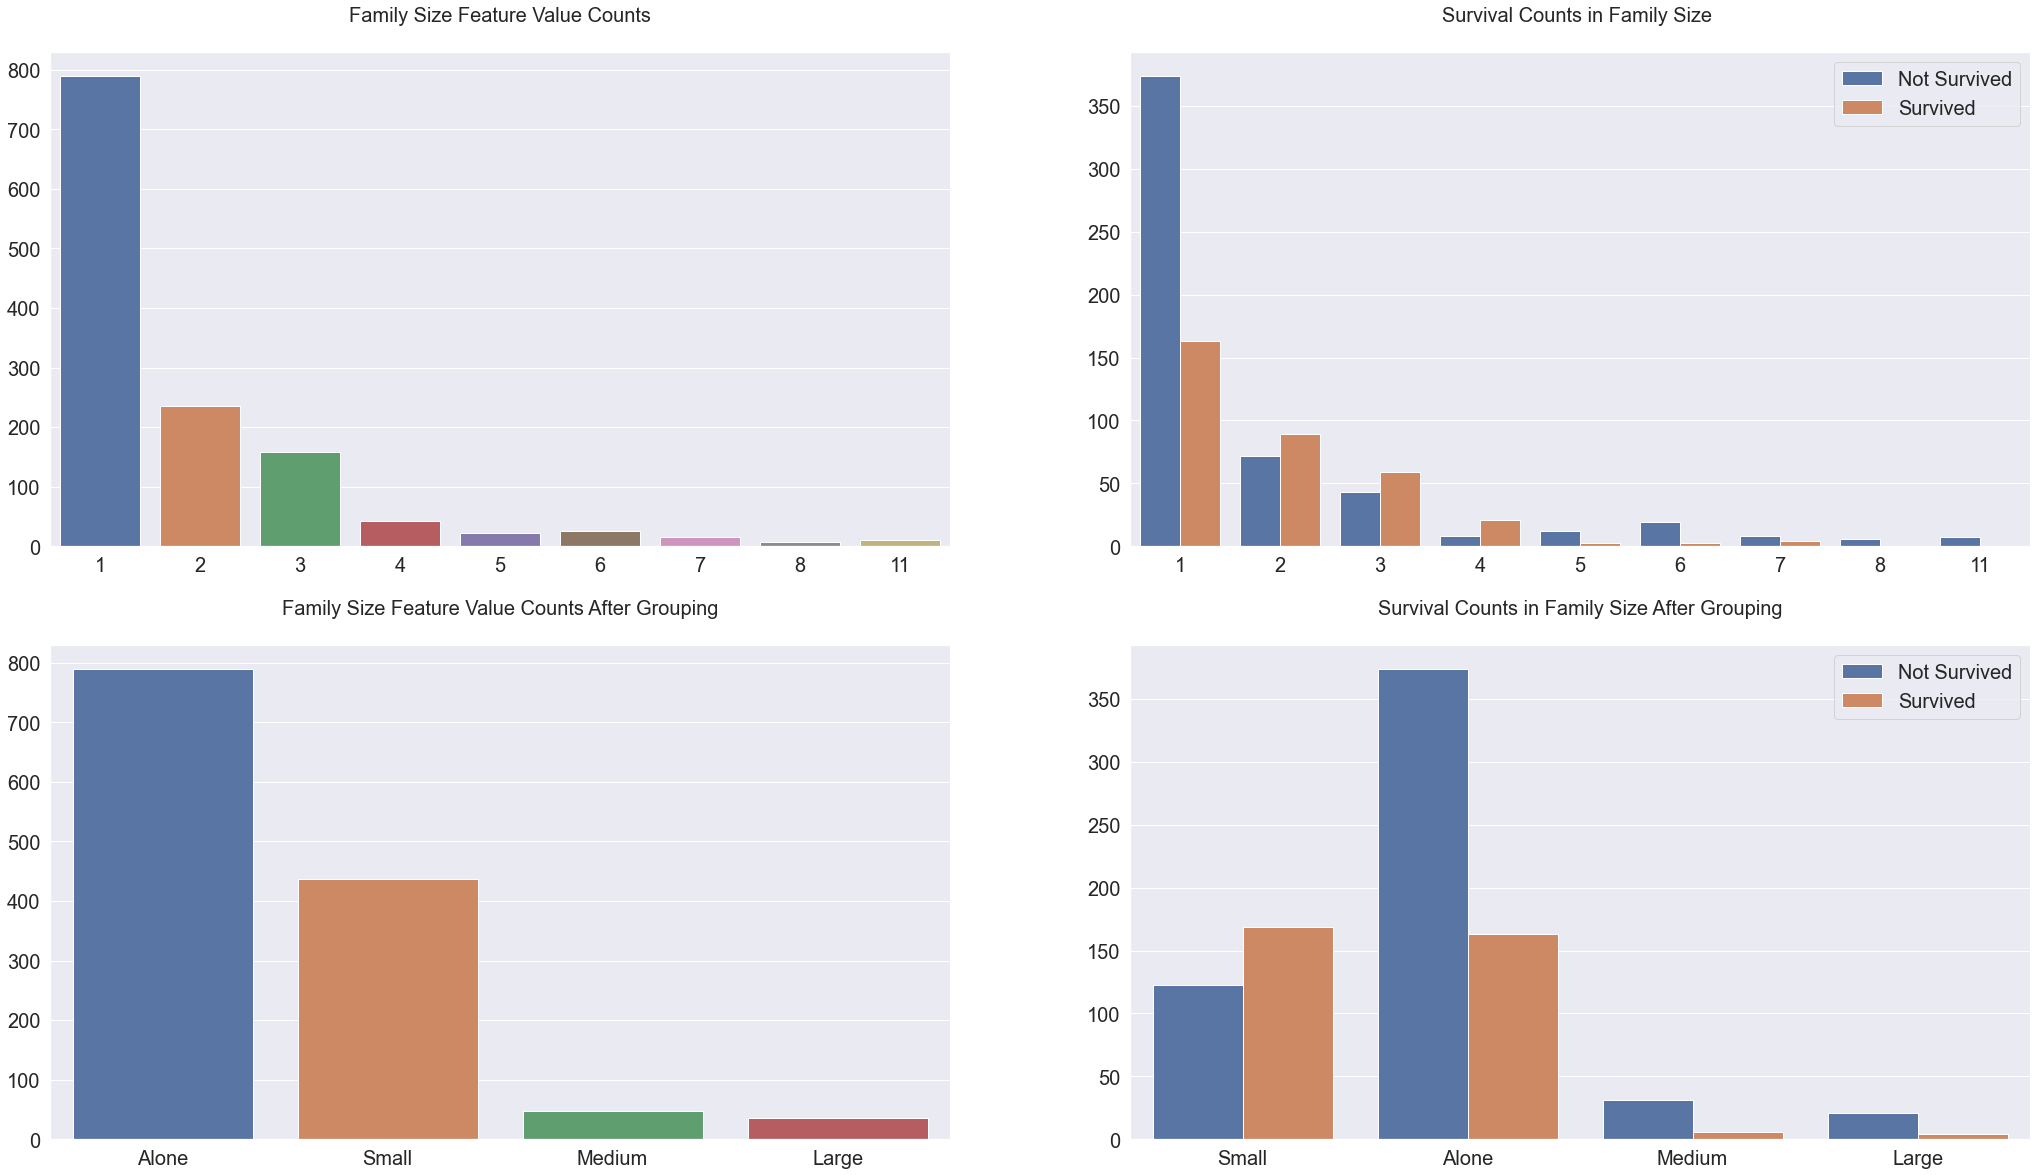

In [570]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

There are too many unique Ticket values to analyze, so grouping them up by their frequencies makes things easier.

How is this feature different than Family_Size? Many passengers travelled along with groups. Those groups consist of friends, nannies, maids and etc. They weren't counted as family, but they used the same ticket.

Why not grouping tickets by their prefixes? If prefixes in Ticket feature has any meaning, then they are already captured in Pclass or Embarked features because that could be the only logical information which can be derived from the Ticket feature.

According to the graph below, groups with 2,3 and 4 members had a higher survival rate. Passengers who travel alone has the lowest survival rate. After 4 group members, survival rate decreases drastically. This pattern is very similar to Family_Size feature but there are minor differences. Ticket_Frequency values are not grouped like Family_Size because that would basically create the same feature with perfect correlation. This kind of feature wouldn't provide any additional information gain.

In [571]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

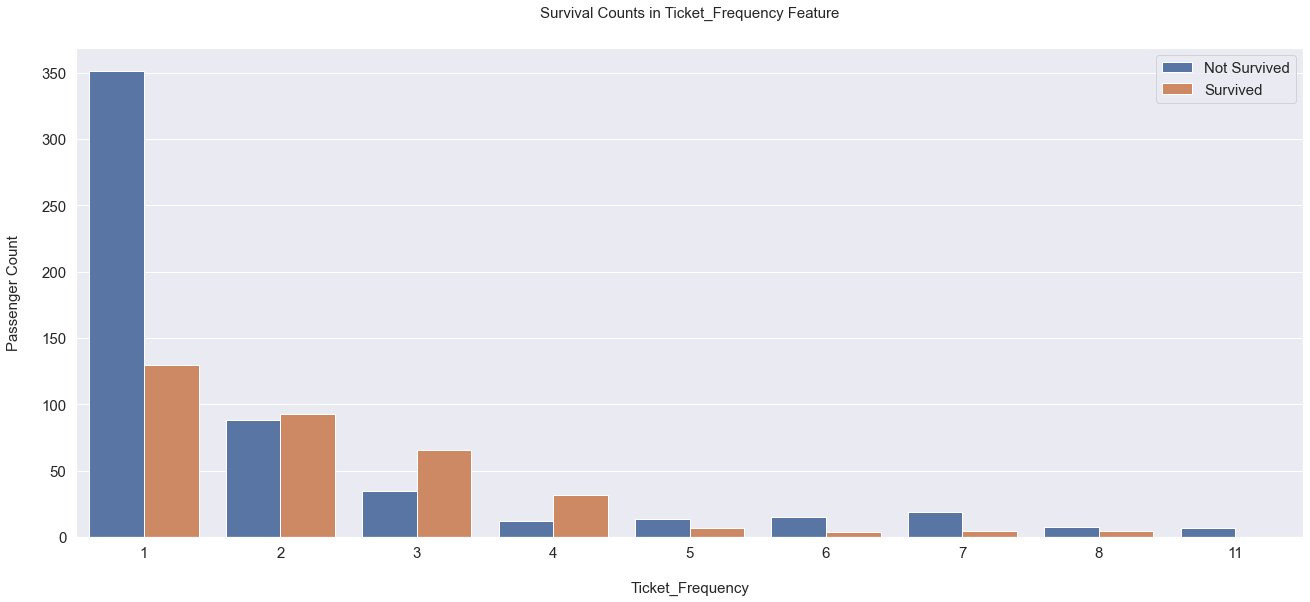

In [572]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket_Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Ticket_Frequency'), size=15, y=1.05)

plt.show()

## 2.3 Title & Is Married

Title is created by extracting the prefix before Name feature. According to graph below, there are many titles that are occuring very few times. Some of those titles doesn't seem correct and they need to be replaced. Miss, Mrs, Ms, Mlle, Lady, Mme, the Countess, Dona titles are replaced with Miss/Mrs/Ms because all of them are female. Values like Mlle, Mme and Dona are actually the name of the passengers, but they are classified as titles because Name feature is split by comma. Dr, Col, Major, Jonkheer, Capt, Sir, Don and Rev titles are replaced with Dr/Military/Noble/Clergy because those passengers have similar characteristics. Master is a unique title. It is given to male passengers below age 26. They have the highest survival rate among all males.

Is_Married is a binary feature based on the Mrs title. Mrs title has the highest survival rate among other female titles. This title needs to be a feature because all female titles are grouped with each other.

In [573]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

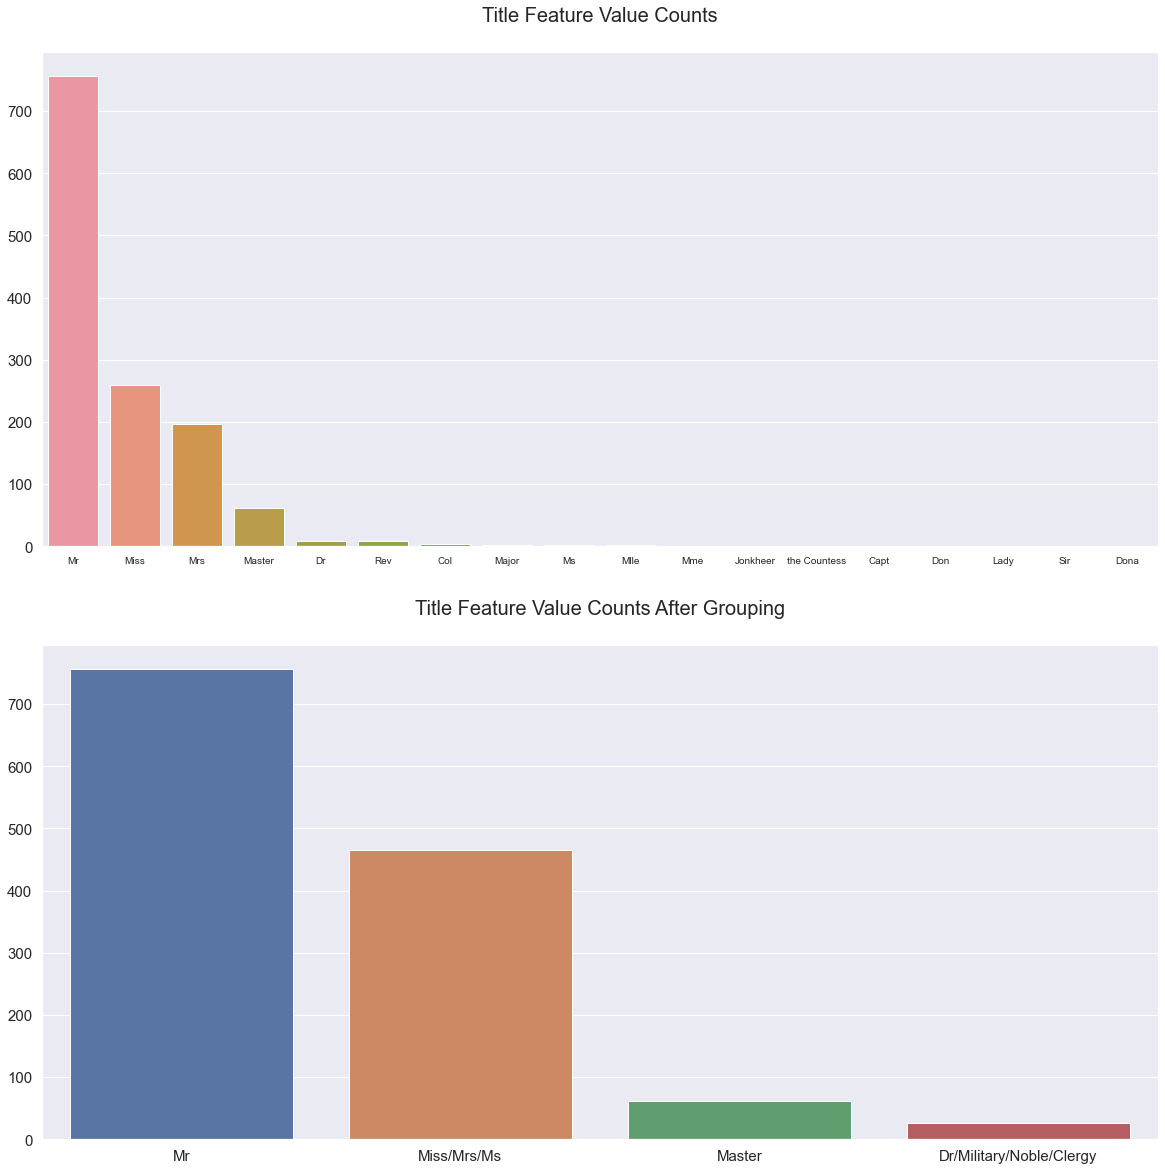

In [574]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

## 2.4 Target Encoding

extract_surname function is used for extracting surnames of passengers from the Name feature. Family feature is created with the extracted surname. This is necessary for grouping passengers in the same family.

In [575]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

In [576]:
df_all['Name']

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
                              ...                        
1304                                   Spector, Mr. Woolf
1305                         Oliva y Ocana, Dona. Fermina
1306                         Saether, Mr. Simon Sivertsen
1307                                  Ware, Mr. Frederick
1308                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [577]:
df_all['Family']

0              Braund
1             Cumings
2           Heikkinen
3            Futrelle
4               Allen
            ...      
1304          Spector
1305    Oliva y Ocana
1306          Saether
1307             Ware
1308            Peter
Name: Family, Length: 1309, dtype: object

Family_Survival_Rate is calculated from families in training set since there is no Survived feature in test set. A list of family names that are occuring in both training and test set (non_unique_families), is created. The survival rate is calculated for families with more than 1 members in that list, and stored in Family_Survival_Rate feature.

An extra binary feature Family_Survival_Rate_NA is created for families that are unique to the test set. This feature is also necessary because there is no way to calculate those families' survival rate. This feature implies that family survival rate is not applicable to those passengers because there is no way to retrieve their survival rate.

Ticket_Survival_Rate and Ticket_Survival_Rate_NA features are also created with the same method. Ticket_Survival_Rate and Family_Survival_Rate are averaged and become Survival_Rate, and Ticket_Survival_Rate_NA and Family_Survival_Rate_NA are also averaged and become Survival_Rate_NA

In [578]:
df_train.groupby('Family')['Survived', 'Family','Family_Size'].median()

,Survived,Family_Size
Family,,
Abbing,0.0,1.0
Abbott,0.5,3.0
Abelson,0.5,2.0
Adahl,0.0,1.0
Adams,0.0,1.0
...,...,...
de Mulder,1.0,1.0
de Pelsmaeker,0.0,1.0
del Carlo,0.0,2.0


In [579]:
df_train.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

,Survived,Ticket_Frequency
Ticket,,
110152,1.0,3
110413,1.0,3
110465,0.0,2
110564,1.0,1
110813,1.0,2
...,...,...
W./C. 6608,0.0,5
W./C. 6609,0.0,1
W.E.P. 5734,0.0,2


In [580]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train.groupby('Family')['Survived', 'Family','Family_Size'].median()
df_ticket_survival_rate = df_train.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [581]:
non_unique_families

['Cumings',
 'McCarthy',
 'Palsson',
 'Sandstrom',
 'Bonnell',
 'Andersson',
 'Rice',
 'Williams',
 'Vander Planke',
 'McGowan',
 'Asplund',
 'Fortune',
 'Spencer',
 'Laroche',
 'Rogers',
 'Lennon',
 'Samaan',
 'Faunthorpe',
 'Ostby',
 'West',
 'Goodwin',
 'Moubarek',
 'Kink',
 'Chronopoulos',
 'Caldwell',
 'Carrau',
 'Ford',
 'Chaffee',
 'Dean',
 'Greenfield',
 'White',
 'Johansson',
 'Moore',
 'Peter',
 'Robins',
 'Weisz',
 'Boulos',
 'Andrew',
 'van Billiard',
 'Olsen',
 'Sage',
 'Cribb',
 'Watt',
 'Goldsmith',
 'Smith',
 'Klasen',
 'Lefebre',
 'Becker',
 'KinkHeilmann',
 'Brown',
 'Carr',
 'Kiernan',
 'Hold',
 'Murphy',
 'Minahan',
 'Rosblom',
 'Touma',
 'Abbott',
 'Olsson',
 'Connolly',
 'Allison',
 'Kelly',
 'McCoy',
 'Keane',
 'Fleming',
 'Hays',
 'Ryerson',
 'Lahtinen',
 'Nilsson',
 'Wick',
 'Spedden',
 'Dennis',
 'Frauenthal',
 'Burns',
 'Fox',
 'Davison',
 'Coutts',
 'Elias',
 'del Carlo',
 'Warren',
 'Harder',
 'Wiklund',
 'Widener',
 'Betros',
 'Nakid',
 'Davies',
 'Oreskov

In [582]:
non_unique_tickets

['PC 17599',
 '17463',
 '349909',
 'PP 9549',
 '382652',
 '345763',
 '347077',
 '19950',
 'PC 17569',
 'SC/Paris 2123',
 '370371',
 '2662',
 '3101295',
 '2926',
 '113509',
 'C.A. 34651',
 'CA 2144',
 '2661',
 'S.O.C. 14879',
 '2680',
 '1601',
 '248738',
 '113059',
 'W./C. 6608',
 'W.E.P. 5734',
 'C.A. 2315',
 'PC 17759',
 'PC 17558',
 '2668',
 'A/5. 3337',
 '228414',
 '2678',
 'C.A. 33112',
 'A/5. 851',
 'PC 17597',
 'CA. 2343',
 '371362',
 'C.A. 33595',
 '4133',
 '230136',
 '315153',
 'F.C.C. 13528',
 '11813',
 '26707',
 '19928',
 '370129',
 '2650',
 'PC 17585',
 'PC 17755',
 'PC 17760',
 'C.A. 2673',
 '19877',
 '113781',
 '367226',
 'PC 17758',
 '11767',
 'PC 17608',
 '250651',
 '36928',
 '16966',
 '386525',
 'C.A. 37671',
 'SC/PARIS 2167',
 '110813',
 '11765',
 '113503',
 'PC 17757',
 '2653',
 '28664',
 '28220',
 '347080',
 '2003',
 'SC/AH 3085',
 '33638',
 '17464',
 '3101298',
 'C.A. 6212',
 '26360',
 'C 4001',
 'PC 17603',
 '226875',
 '12749',
 'PC 17483',
 'PC 17761',
 '364498',


In [583]:
df_family_survival_rate

,Survived,Family_Size
Family,,
Abbing,0.0,1.0
Abbott,0.5,3.0
Abelson,0.5,2.0
Adahl,0.0,1.0
Adams,0.0,1.0
...,...,...
de Mulder,1.0,1.0
de Pelsmaeker,0.0,1.0
del Carlo,0.0,2.0


In [584]:
df_ticket_survival_rate

,Survived,Ticket_Frequency
Ticket,,
110152,1.0,3
110413,1.0,3
110465,0.0,2
110564,1.0,1
110813,1.0,2
...,...,...
W./C. 6608,0.0,5
W./C. 6609,0.0,1
W.E.P. 5734,0.0,2


In [585]:
family_rates

{'Abbott': 0.5,
 'Aks': 1.0,
 'Allison': 0.0,
 'Andersson': 0.0,
 'Angle': 1.0,
 'Asplund': 1.0,
 'Astor': 1.0,
 'Becker': 1.0,
 'Boulos': 0.0,
 'Brown': 1.0,
 'Bryhl': 0.0,
 'Caldwell': 1.0,
 'Caram': 0.0,
 'Cardeza': 1.0,
 'Cavendish': 0.0,
 'Chaffee': 0.0,
 'Chapman': 0.0,
 'Christy': 1.0,
 'Chronopoulos': 0.0,
 'Clarke': 1.0,
 'Compton': 1.0,
 'Coutts': 1.0,
 'Cribb': 0.0,
 'Crosby': 0.5,
 'Cumings': 1.0,
 'Danbom': 0.0,
 'Davidson': 0.0,
 'Davies': 0.0,
 'Davison': 1.0,
 'Dean': 0.5,
 'Dodge': 1.0,
 'Douglas': 0.0,
 'Drew': 1.0,
 'Duran y More': 1.0,
 'Elias': 0.0,
 'Faunthorpe': 1.0,
 'Ford': 0.0,
 'Fortune': 0.5,
 'Frauenthal': 1.0,
 'FrolicherStehli': 1.0,
 'Gale': 0.0,
 'Giles': 0.0,
 'Goldsmith': 1.0,
 'Goodwin': 0.0,
 'Greenfield': 1.0,
 'Hansen': 0.0,
 'Harder': 1.0,
 'Hays': 1.0,
 'Herman': 1.0,
 'Hirvonen': 1.0,
 'Hocking': 0.5,
 'Hold': 0.0,
 'Ilmakangas': 0.0,
 'Johnston': 0.0,
 'Karun': 1.0,
 'Kenyon': 1.0,
 'Kiernan': 0.0,
 'Kimball': 1.0,
 'Kink': 0.0,
 'KinkHeilmann

In [586]:
ticket_rates

{'110813': 1.0,
 '112058': 0.0,
 '113059': 0.0,
 '113503': 0.0,
 '113509': 0.0,
 '113773': 0.0,
 '113781': 0.5,
 '113796': 0.0,
 '11753': 1.0,
 '11765': 1.0,
 '11767': 1.0,
 '11769': 1.0,
 '11813': 1.0,
 '12749': 1.0,
 '13567': 1.0,
 '1601': 1.0,
 '16966': 1.0,
 '17463': 0.0,
 '17464': 1.0,
 '19877': 0.5,
 '19928': 0.5,
 '19950': 0.5,
 '2003': 1.0,
 '220845': 1.0,
 '226875': 1.0,
 '228414': 1.0,
 '230136': 1.0,
 '236853': 0.0,
 '237789': 1.0,
 '24160': 1.0,
 '244358': 0.0,
 '248738': 1.0,
 '250651': 0.0,
 '2625': 1.0,
 '26360': 1.0,
 '2650': 1.0,
 '2653': 1.0,
 '2661': 1.0,
 '2662': 0.0,
 '2668': 1.0,
 '26707': 0.0,
 '2678': 0.0,
 '2680': 0.0,
 '2689': 0.0,
 '28220': 1.0,
 '28664': 0.0,
 '29103': 1.0,
 '29105': 1.0,
 '2926': 1.0,
 '29750': 0.5,
 '3101295': 0.0,
 '3101298': 1.0,
 '315153': 1.0,
 '33638': 1.0,
 '345572': 1.0,
 '345763': 0.0,
 '347077': 1.0,
 '347080': 0.0,
 '349256': 1.0,
 '349909': 0.0,
 '349910': 0.0,
 '350026': 0.0,
 '364498': 0.0,
 '36568': 0.0,
 '367226': 1.0,
 '369

In [587]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [588]:
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2    

In [589]:
train_family_survival_rate

[0.3838383838383838,
 1.0,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.0,
 0.3838383838383838,
 0.3838383838383838,
 1.0,
 0.3838383838383838,
 0.3838383838383838,
 0.0,
 0.3838383838383838,
 0.3838383838383838,
 0.0,
 0.3838383838383838,
 0.0,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.0,
 1.0,
 0.3838383838383838,
 0.5,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 1.0,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.0,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 1.0,
 0.3838383838383838,
 0.3838383838383838,
 0.0,
 0.3838383838383838,
 0.0,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 1.0,
 0.0,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 1.0,
 0.0,
 0.3838383

In [590]:
train_family_survival_rate_NA

[0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,


In [591]:
test_family_survival_rate

[0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 1.0,
 0.3838383838383838,
 0.3838383838383838,
 1.0,
 0.3838383838383838,
 0.0,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.0,
 0.0,
 0.3838383838383838,
 0.3838383838383838,
 0.0,
 0.3838383838383838,
 1.0,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 1.0,
 0.0,
 0.0,
 0.3838383838383838,
 0.3838383838383838,
 0.0,
 1.0,
 0.3838383838383838,
 0.5,
 0.0,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 1.0,
 0.3838383838383838,
 1.0,
 0.3838383838383838,
 1.0,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 1.0,
 0.3838383838383838,
 0.3838383838383838,
 0.5,
 0.5,
 0.3838383838383838,
 0.0,
 0.3838383838383838,
 0.3838383838383838,
 1.0,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838383838383838,
 0.3838

In [592]:
test_family_survival_rate_NA

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,


## 2.5 Feature Transformation

### 2.5.1 Label Encoding Non-Numerical Features

Embarked, Sex, Deck , Title and Family_Size_Grouped are object type, and Age and Fare features are category type. They are converted to numerical type with LabelEncoder. LabelEncoder basically labels the classes from 0 to n. This process is necessary for models to learn from those features.

In [593]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

### 2.5.2 One-Hot Encoding the Categorical Features

The categorical features (Pclass, Sex, Deck, Embarked, Title) are converted to one-hot encoded features with OneHotEncoder. Age and Fare features are not converted because they are ordinal unlike the previous ones.

In [594]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

## 2.6 Conclusion

Age and Fare features are binned. Binning helped dealing with outliers and it revealed some homogeneous groups in those features. Family_Size is created by adding Parch and SibSp features and 1. Ticket_Frequency is created by counting the occurence of Ticket values.

Name feature is very useful. First, Title and Is_Married features are created from the title prefix in the names. Second, Family_Survival_Rate and Family_Survival_Rate_NA features are created by target encoding the surname of the passengers. Ticket_Survival_Rate is created by target encoding the Ticket feature. Survival_Rate feature is created by averaging the Family_Survival_Rate and Ticket_Survival_Rate features.

Finally, the non-numeric type features are label encoded and categorical features are one-hot encoded. Created 5 new features (Family_Size, Title, Is_Married, Survival_Rate and Survival_Rate_NA) and dropped the useless features after encoding.

In [595]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


In [596]:
df_all.columns

Index(['Age', 'Deck_1', 'Deck_2', 'Deck_3', 'Deck_4', 'Embarked_1',
       'Embarked_2', 'Embarked_3', 'Family_Size_Grouped_1',
       'Family_Size_Grouped_2', 'Family_Size_Grouped_3',
       'Family_Size_Grouped_4', 'Fare', 'Is_Married', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_1', 'Sex_2', 'Survival_Rate', 'Survival_Rate_NA',
       'Ticket_Frequency', 'Title_1', 'Title_2', 'Title_3', 'Title_4'],
      dtype='object')

# 3. Model

In [597]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


## 3.1 Random Forest

Created 2 RandomForestClassifier's. One of them is a single model and the other is for k-fold cross validation.

The highest accuracy of the single_best_model is 0.82775 in public leaderboard. However, it doesn't perform better in k-fold cross validation. It is a good model to start experimenting and hyperparameter tuning.

The highest accuracy of leaderboard_model is 0.83732 in public leaderboard with 5-fold cross validation. This model is created for leaderboard score and it is tuned to overfit slightly. It is designed to overfit because the estimated probabilities of X_test in every fold are going to be divided by N (fold count). If this model is used as a single model, it would struggle to predict lots of samples correctly.

Which model should I use?

- leaderboard_model overfits to test set so it's not suggested to use models like this in real life projects.
- single_best_model is a good model to start experimenting and learning about decision trees.

In [598]:
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 

StratifiedKFold is used for stratifying the target variable. The folds are made by preserving the percentage of samples for each class in target variable (Survived).

In [599]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

In [600]:
probs

,Fold_1_Prob_0,Fold_1_Prob_1,Fold_2_Prob_0,Fold_2_Prob_1,Fold_3_Prob_0,Fold_3_Prob_1,Fold_4_Prob_0,Fold_4_Prob_1,Fold_5_Prob_0,Fold_5_Prob_1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [601]:
importances

,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
Age,0.0,0.0,0.0,0.0,0.0
Deck_1,0.0,0.0,0.0,0.0,0.0
Deck_2,0.0,0.0,0.0,0.0,0.0
Deck_3,0.0,0.0,0.0,0.0,0.0
Deck_4,0.0,0.0,0.0,0.0,0.0
Embarked_1,0.0,0.0,0.0,0.0,0.0
Embarked_2,0.0,0.0,0.0,0.0,0.0
Embarked_3,0.0,0.0,0.0,0.0,0.0
Family_Size_Grouped_1,0.0,0.0,0.0,0.0,0.0
Family_Size_Grouped_2,0.0,0.0,0.0,0.0,0.0


In [602]:
skf = StratifiedKFold(n_splits=N, random_state=SEED, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_
        
    oob += leaderboard_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 1 OOB Score: 0.8342696629213483

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 2 OOB Score: 0.8485273492286115

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 3 OOB Score: 0.8485273492286115

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 4 OOB Score: 0.8429172510518934

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

Fold 5 OOB Score: 0.8387096774193549

Average OOB Score: 0.8425902579699639


## 3.2 Feature Importance

In [607]:
importances

,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,Mean_Importance
Ticket_Frequency,0.144994,0.126246,0.147239,0.132734,0.145016,0.139246
Deck_4,0.140375,0.139599,0.135961,0.125267,0.126443,0.133529
Family_Size_Grouped_3,0.120312,0.135801,0.123374,0.133290,0.119754,0.126506
Family_Size_Grouped_2,0.120645,0.127419,0.123313,0.132998,0.114970,0.123869
Survival_Rate_NA,0.118087,0.112967,0.101996,0.111331,0.099778,0.108832
Family_Size_Grouped_1,0.057871,0.053968,0.056900,0.043280,0.055895,0.053583
Deck_1,0.044466,0.043876,0.048055,0.047238,0.052036,0.047134
Deck_2,0.036911,0.039702,0.037698,0.035074,0.042701,0.038417
Pclass_1,0.031678,0.029995,0.039879,0.039104,0.040500,0.036231
Age,0.028715,0.026572,0.031380,0.031727,0.031907,0.030060


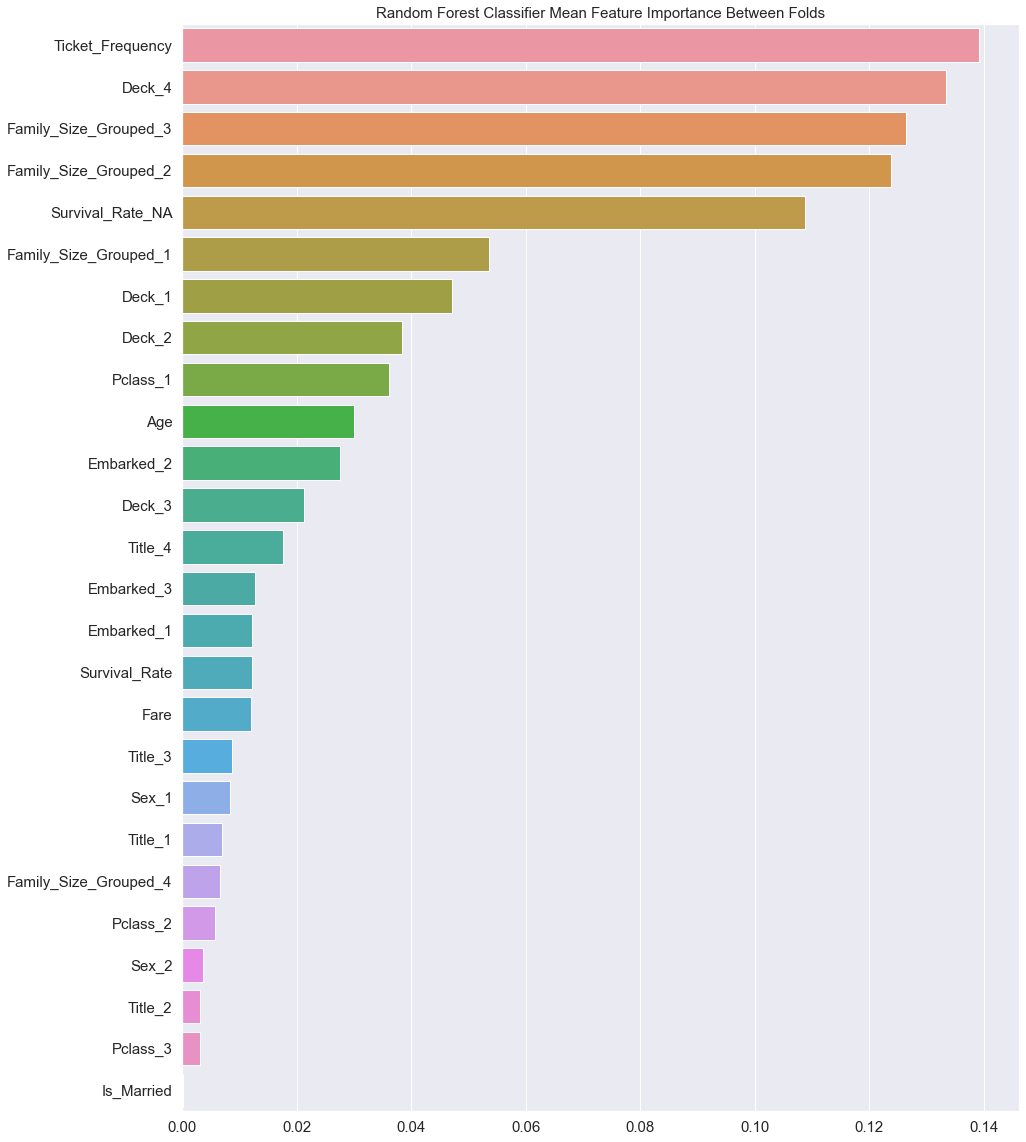

In [603]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

## 3.3 ROC Curve

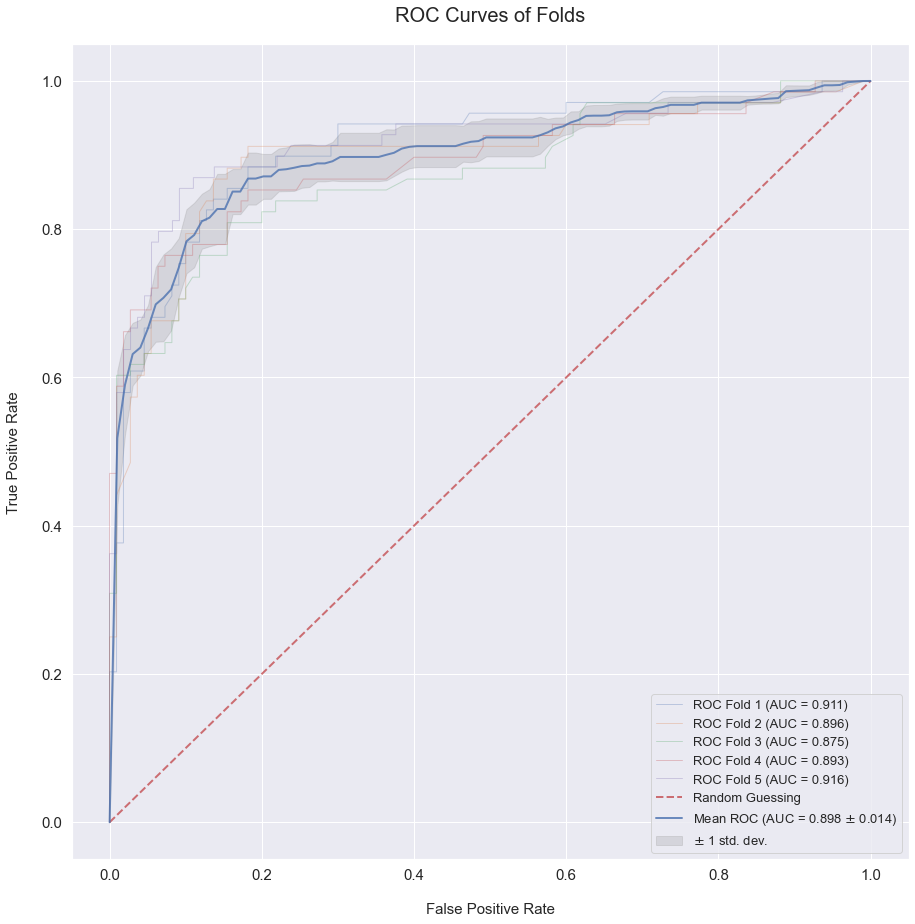

In [605]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

plot_roc_curve(fprs, tprs)

## 3.4 Submission

In [606]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0
